# 21/10/2020

## Mathematical morphology (morphologie mathématique)

### Objectif
* appliquer et comparer les opérations de base (érosion, dilatation, ouverture, fermeture)
* évaluer les influences des paramètres de ces opérations
* utiliser les composantes connexes à bon escient

In [1]:
from skimage.io import imread
from skimage.measure import regionprops
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing, disk, label
from matplotlib.pyplot import imshow, figure, hist, show, subplot, title, plot
from numpy import arange

L'image moliets.png est une vue satellitaire d'une petite commune des Landes. C'est une image RVB de résolution 50 cm.

In [2]:
img = imread('moliets.png')

Étant donné que les objets recherchés sont plutôt bleus, et qu'aucun autre objet de la scène n'est de cette couleur, il peut être intéressant de travailler uniquement sur la bande bleue des images (où les piscines apparaîtrons très lumineuses) plutôt que, par exemple, sur l'image à niveau de gris. Cela permet une première discrimination entre les piscines et le reste.

In [3]:
blue = img[:,:,2]

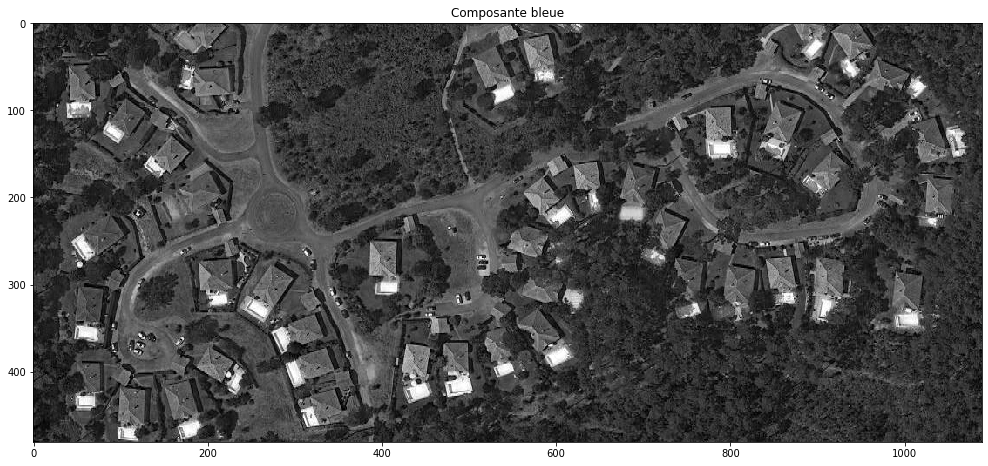

In [4]:
figure(figsize=(17,10))
imshow(blue, cmap='gray')
title('Composante bleue')
show()

Les opérateurs de morphologie mathématique vu en cours fonctionnent sur des images binaires. La bande bleue peut dont être binarisée en la seuillant, et le seuil peut peut être choisi en observant l'histogramme de la bande bleue. Or, il s'avère que pour cette image, l'histogramme ne nous aide pas car on ne distingue pas deux classes dinstinctes.

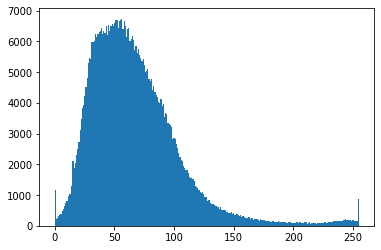

In [5]:
hist(blue.ravel(), bins=256)
show()

Le seuil est donc réglé « à la main », en procédant par essais-erreurs de manière à obtenir un résultat satisfaisant . On choisit un seuil égal à 240.

In [6]:
binarized = (blue > 240)

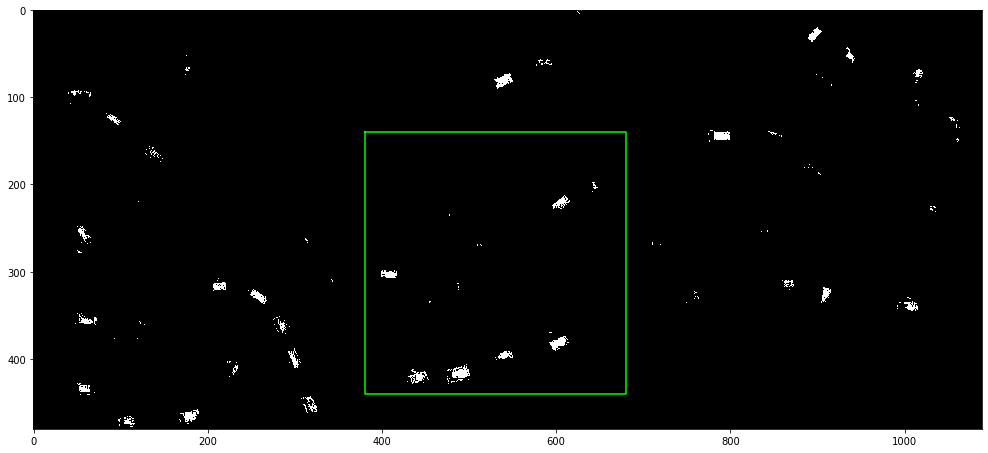

In [7]:
xmin, xmax, ymin, ymax = 380, 680, 140, 440
figure(figsize=(17,10))
imshow(binarized, cmap='gray')
plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color=[0,1,0])
show()

### Étude des différents opérateurs

Dans cette partie, les opérateurs de la morphologie mathématique seront appliqués à la portion encadrée de l'image, reproduite ci-dessous.

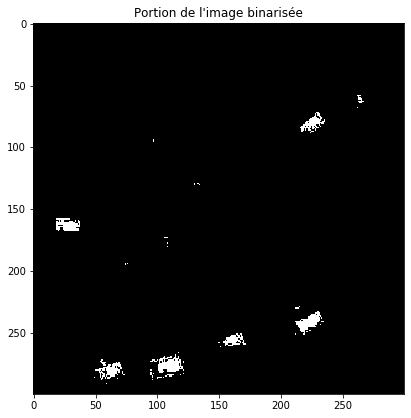

In [8]:
crop = binarized[ymin:ymax,xmin:xmax]
figure(figsize=(17,15))
subplot(2,2,1)
imshow(crop, cmap='gray')
title("Portion de l'image binarisée")
show()

Pour commencer, nous choisissons comme élément structurant un disque de rayon 4 pixels.

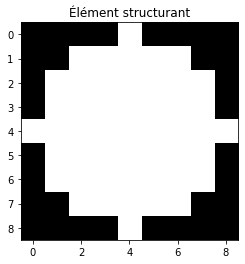

In [9]:
selem = disk(4)
imshow(selem, cmap='gray')
title("Élément structurant")
show()

Les quatre opérateurs de base appliqués sur l'image produisent les résultats ci-dessous.

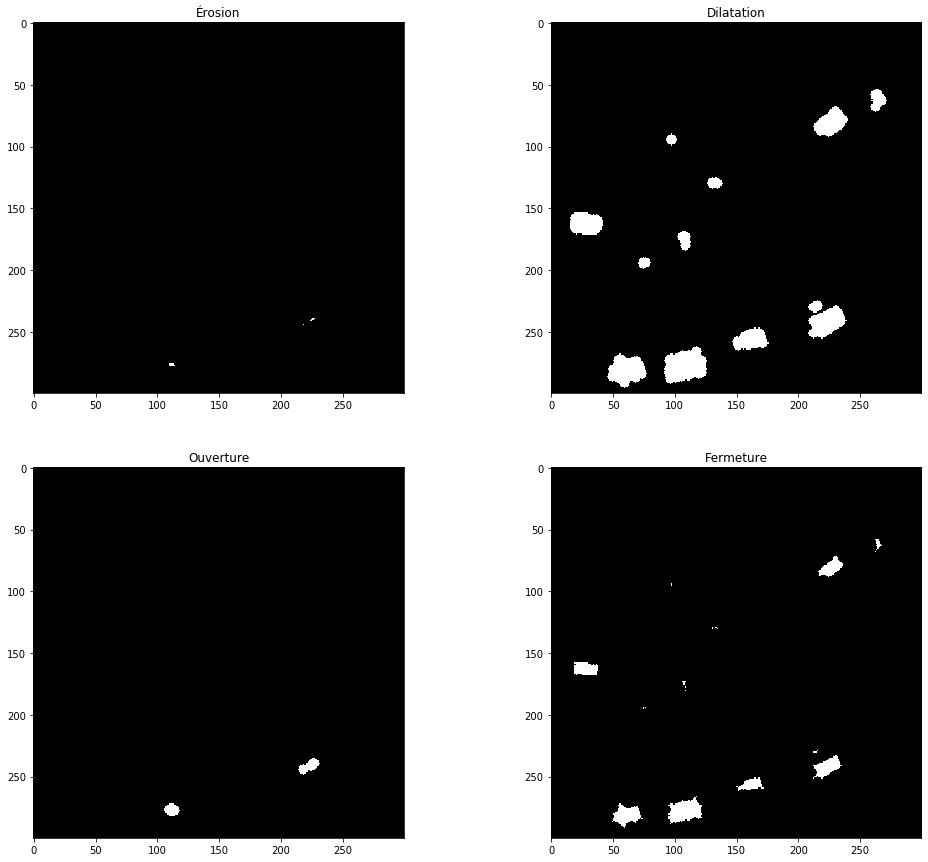

In [10]:
g_erosion = binary_erosion(crop, selem)
g_dilation = binary_dilation(crop, selem)
g_opening = binary_opening(crop, selem)
g_closing = binary_closing(crop, selem)

figure(figsize=(17,15))
subplot(2,2,1)
imshow(g_erosion, cmap='gray')
title('Érosion')
subplot(2,2,2)
imshow(g_dilation, cmap='gray')
title('Dilatation')
subplot(2,2,3)
imshow(g_opening, cmap='gray')
title('Ouverture')
subplot(2,2,4)
imshow(g_closing, cmap='gray')
title('Fermeture')
show()

* Quel(s) opérateur(s) tend(ent) à boucher les trous des objets ?
* Au contraire, quel(s) opérateur(s) tend(ent) à supprimer les petits objets ?
* Quel(s) opérateur(s) conserve(nt) (à peu près) la forme des objets ?

Même chose avec un disque de rayon 10 pixels :

In [11]:
selem = disk(10)

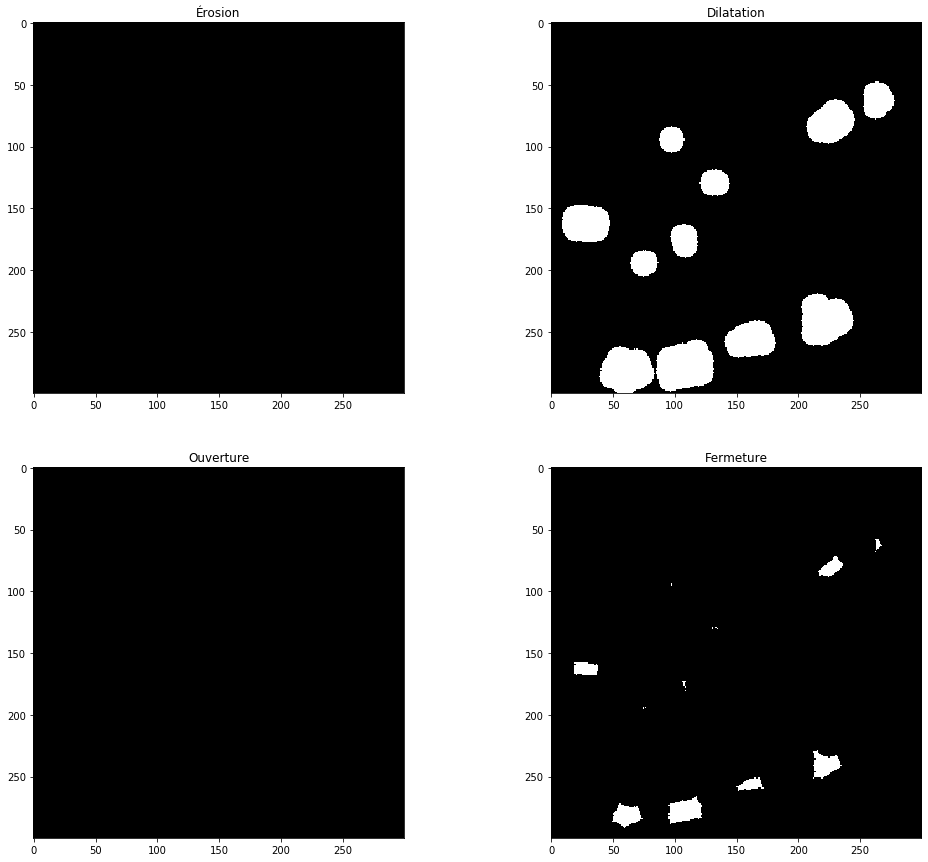

In [12]:
g_erosion = binary_erosion(crop, selem)
g_dilation = binary_dilation(crop, selem)
g_opening = binary_opening(crop, selem)
g_closing = binary_closing(crop, selem)

figure(figsize=(17,15))
subplot(2,2,1)
imshow(g_erosion, cmap='gray')
title('Érosion')
subplot(2,2,2)
imshow(g_dilation, cmap='gray')
title('Dilatation')
subplot(2,2,3)
imshow(g_opening, cmap='gray')
title('Ouverture')
subplot(2,2,4)
imshow(g_closing, cmap='gray')
title('Fermeture')
show()

N'hésitez pas à tester d'autres éléments structurants pour observer leur influence.

### Détection des piscines

Dans la suite, on travaille avec le résultat d'une fermeture avec comme élément structurant un disque de rayon 10 pixels.

La fonction `skimage.morphology.label` retourne une labellisation des différentes composantes connexes, et la fonction `skimage.measure.regionprops` permet de mesurer certaines propriétés des composantes connexes, comme leur surface ou leur position. 

In [13]:
# Élément structurant
selem = disk(10)

# Fermeture
img_closing = binary_closing(binarized, selem)

# Labellisation des composantes connexes
labels = label(img_closing, connectivity=2)

# Mesure des propriétés des composantes connexes
props = regionprops(labels)

# Nombre de composantes connexes
N = len(props)
print('Nombre de composantes connexes, donc de piscines détectées : {}'.format(N))

# Quelques propriétés de la région 0
n = 0
print('La région {} contient {} pixels et son centroïde a pour coordonnées {}.'.format(
    n, props[n].area, props[n].centroid))

Nombre de composantes connexes, donc de piscines détectées : 69
La région 0 contient 29 pixels et son centroïde a pour coordonnées (1.0344827586206897, 624.4137931034483).


Les centres des composantes connexes sont représentés dans l'image ci-dessous par les points rouges.

Bien sûr il n'y a pas autant de piscines dans l'image : une grande partie des composantes connexes sont en fait des petits groupes de pixels qui ne correspondent pas à des piscines.

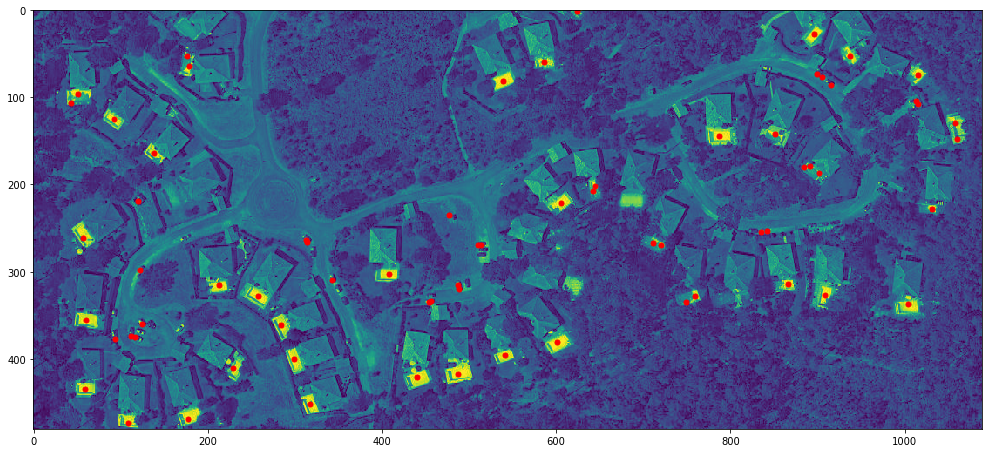

In [14]:
figure(figsize=(17,10))
imshow(blue)
for n in range(N):
    plot(props[n].centroid[1], props[n].centroid[0], 'r.', markersize=10)
show()


Une amélioration est de considérer uniquement les composantes connexes dont le nombre de pixels est supérieur à un certain seuil. Dans notre cas, nous avons choisi de considérer comme étant des piscines les composantes connexes dont l'aire est supérieure à 20 pixels.

Par ailleurs, comme un pixel représente une surface de 0,5 x 0,5 m<sup>2</sup>, on en déduit la surface moyenne des piscines détectées.

Nombre de piscines détectées : 36
Surface moyenne des piscines détectées : 40.89 m²


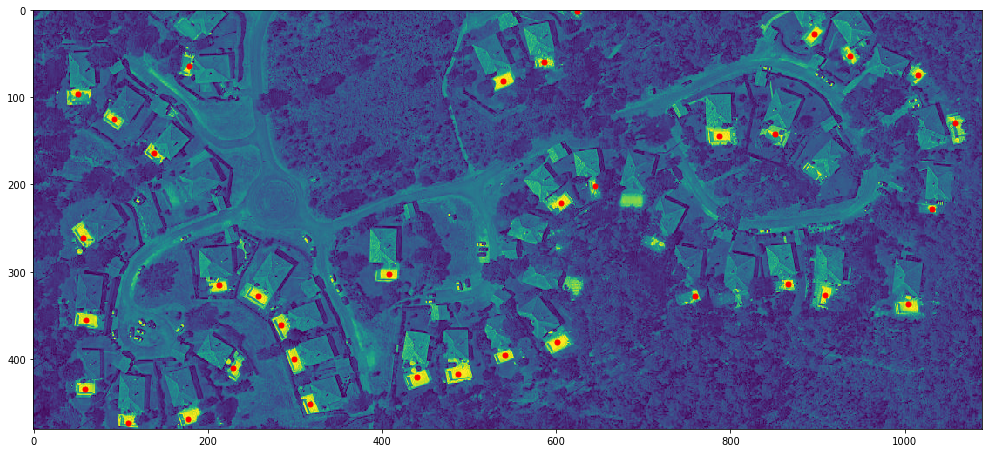

In [15]:
N = 0  # Nombre de piscines
A = 0  # Aire totale des piscines
figure(figsize=(17,10))
imshow(blue)
for r in props:
    if r.area > 20:
        N = N + 1
        A = A + r.area
        plot(r.centroid[1], r.centroid[0], 'r.', markersize=10)

print('Nombre de piscines détectées : {}'.format(N))
print('Surface moyenne des piscines détectées : {:.2f} m²'.format(A/N*.5*.5))
show()

### Critique de la méthode

Bien entendu, la méthode développée ici est simple et peu robuste : les piscines ombragées ou cachées en partie par un arbre ne sont pas toujours détectées. À l'inverse, certains objets peuvent être considérés comme des piscines car ils sont très lumineux dans la bande bleue et de taille importante. Aussi, quelques améliorations sont listées ci-dessous (la liste n'est pas exhaustive !) :

* la méthode proposée ne se base que sur la couleur bleue. Elle pourrait également prendre en compte la géométrie des composantes connexes : les piscines sont des objets bleus, suffisamment gros, et de forme plutôt rectangulaire (la notion de [_bounding box_](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html) peut alors être utile) ;
* le choix du seuil est fixé et fonctionne bien sur cette image. Mais rien n'assure que la valeur choisie puisse s'appliquer sur une autre image : rien ne permet de dire que cette méthode est robuste à la résolution du capteur, à la luminosité lors de la prise de vue, au type de piscine, etc. ;
* la binarisation de l'image pourrait prendre en compte, en plus de la luminosité des pixels, la classe dans laquelle se trouvent les pxels voisins. Ce principe est souvent modélisé à l'aide de champs de Markov.

## Registration (recalage)

### Objectif

L'objectif de cet exercice est d'appréhender le problème du recalage par un premier exemple simple.

Les deux images à recaler sont :

In [16]:
import numpy as np
import skimage.io as io
import skimage.transform as tr
import matplotlib.pyplot as plt

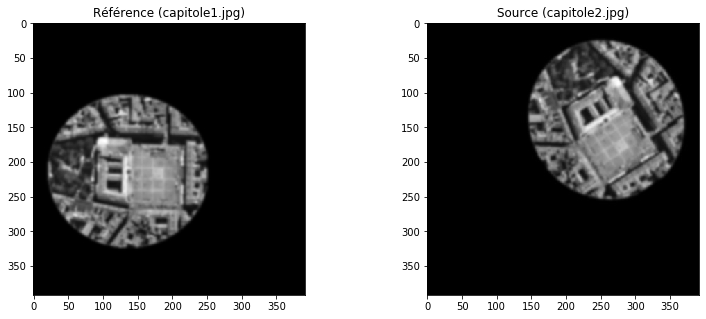

In [17]:
# Images

# http://www.cnes-csg.fr/web/CNES-en/9844-gp-first-pleiades-satellite-to-launch-16-december.php

f = io.imread("capitole1.jpg")
g = io.imread("capitole2.jpg")
(M, N) = f.shape

f = f/255
g = g/255

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(f, "gray")
plt.title("Référence (capitole1.jpg)")
plt.subplot(1,3,2)
plt.imshow(g, "gray")
plt.title("Source (capitole2.jpg)")
plt.show()

Pour recaler la source sur la référence, l'image doit subir une rotation et une translation : il s'agit donc d'une déformation rigide, appelée aussi euclidienne car elle préserve la distance euclidienne entre les pixels de l'image.
Cette déformation correspond à appliquer deux opérations :
* une rotation de l'image d'un angle $\theta$ est d'abord appliquée, autour du pixel $(0,0)$ (le coin en haut à gauche de l'image),
* une translation $(x,y)$ est ensuite effectuée, la translation s'effectuant suivant le nouveau repère de l'image (selon la rotation précédente).

La déformation rigide est donc définie par trois paramètres : une translation $(x,y)$ et une rotation $\theta$.
La fonction `skimage.transform.EuclideanTransform` permet de définir une telle déformation.
L'image est transformée selon cette déformation avec la fonction `skimage.transform.warp` :

```
transformation = transform.EuclideanTransform(translation=(x,y), rotation=t)
h = transform.warp(g, transformation)
```

Une transformation de rotation $\pi/3$ et de translation $(400,-100)$ donne ainsi :

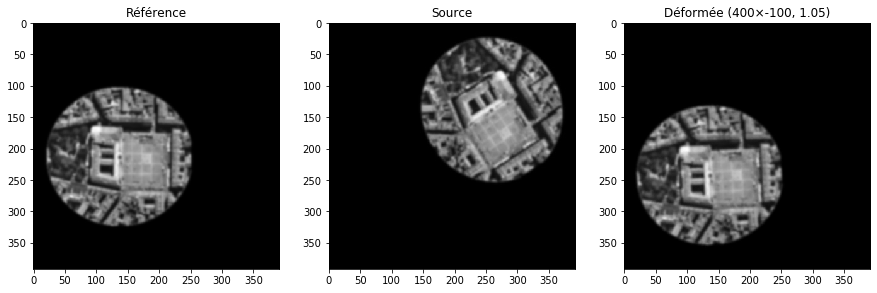

In [18]:
# Transformation test
# Attention, la rotation se fait autour du pixel (0,0)
# A Euclidean transformation, also called rigid transformation, preserves the Euclidean distance between pairs of points.
# It can be described as a rotation about the origin followed by a translation.
# Les axes sont subissent également la rotation, de sorte que la translation se fait suivant les axes tranformés.

x, y, t = 400, -100, np.pi/3
trans = tr.EuclideanTransform(translation=(x,y), rotation=t)
h = tr.warp(g, trans)

# Affichage
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(f, "gray")
plt.title("Référence")
plt.subplot(1,3,2)
plt.imshow(g, "gray")
plt.title("Source")
plt.subplot(1,3,3)
plt.imshow(h, "gray")
plt.title(f"Déformée ({x}×{y}, {t:.3})")
plt.show()

On peut comparer visuellement la différence entre la référence et l'image déformée (attention : vérifiez que les images ont la même dynamique !)...

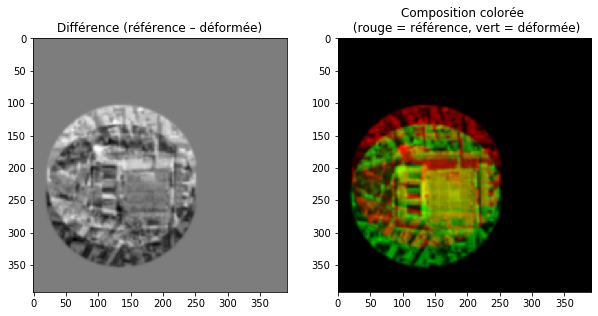

In [19]:
# EQM
eqm = np.linalg.norm(f-h)**2/(M*N)

# Composition colorée
c = np.zeros((M, N, 3))
c[:,:,0] = f
c[:,:,1] = h

# Affichage
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(f-h, "gray")
plt.title("Différence (référence – déformée)")
plt.subplot(1,2,2)
plt.imshow(c)
plt.title("Composition colorée \n (rouge = référence, vert = déformée)")
plt.show()

...ou en calculant l'EQM entre ces deux images :

In [20]:
print(f"EQM = {eqm:.3e}")

EQM = 2.537e-02


Sans autre valeur de comparaison, on ne peut pas dire, uniquement à partir de l'EQM, si le résultat est bon ou pas.
On voit cependant sur la différence entre les deux images que le recalage n'est pas encore très bon.

Il faut donc optimiser le critère de similarité (ici, l'EQM) en fonction des paramètres de la transformation ($x$, $y$, $\theta$).
Bien qu'il existe beaucoup de méthodes d'optimisation très efficaces, nous allons ici utiliser une méthode toute simple qui consiste à essayer toutes les valeurs de ces trois paramètres.
Pour chaque triplet $(x,y,\theta)$ il faudra donc appliquer la déformation et calculer l'EQM : si le nombre de combinaison est grand, le temps de calcul sera vite très long !

L'idée est donc de tester certains triplets $(x,y,\theta)$ autour de $(400,-100,\pi/3)$ testé précédemment.
Par exemple, on choisit de tester les valeurs selons les intervalles :

$$
x \in [300,500], \quad
y \in [-200,0], \quad
\theta \in [0,\pi].
$$

De plus, il faut commencer par un pas assez grossier, par exemple en allant de 10 en 10 pour les translations, et de $1$ en $1$ pour la rotation.
En fonction du résultat obtenu, on pourra ensuite affiner l'espace de recherche.

Le résultat obtenu de cette manière est le suivant :

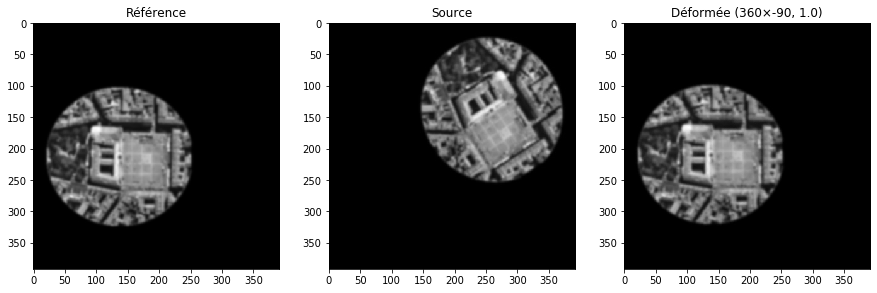

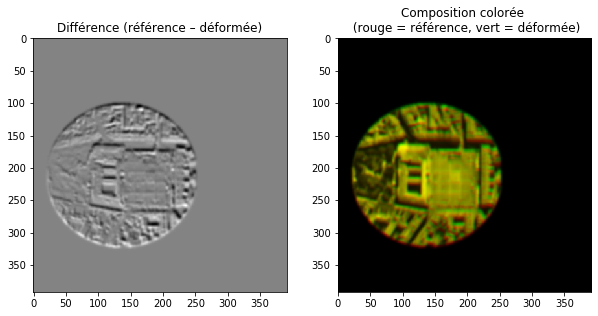

In [21]:
# Recherche de la meilleure transformation (sur une grille)

eqmmin = np.inf

for x in np.arange(300, 400, 10):
    for y in np.arange(-150, -50, 10):
        for t in np.arange(0, 2*np.pi, 1):
            
            # Transformation
            trans = tr.EuclideanTransform(translation=(x,y), rotation=t)
            h = tr.warp(g, trans)
            
            # EQM
            eqm = np.linalg.norm(f-h)**2/(M*N)
            if eqm < eqmmin:
                eqmmin = eqm
                xopt = x
                yopt = y
                topt = t

# Recalage estimé
trans = tr.EuclideanTransform(translation=(xopt,yopt), rotation=topt)
hopt = tr.warp(g, trans)

# Images
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(f, "gray")
plt.title("Référence")
plt.subplot(1,3,2)
plt.imshow(g, "gray")
plt.title("Source")
plt.subplot(1,3,3)
plt.imshow(hopt, "gray")
plt.title(f"Déformée ({xopt}×{yopt}, {topt:.3})")
plt.show()

# Différences
c[:,:,0] = f
c[:,:,1] = hopt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(f-hopt, "gray")
plt.title("Différence (référence – déformée)")
plt.subplot(1,2,2)
plt.imshow(c)
plt.title("Composition colorée \n (rouge = référence, vert = déformée)")
plt.show()

L'EQM est plus faible que celle obtenue ci-avant, ce qui montre que le recalage est meilleur :

In [22]:
# EQM
eqm = np.linalg.norm(f-hopt)**2/(M*N)
print(f"EQM = {eqm:.3e}")

EQM = 4.144e-03
